In [1]:
import os
import glob
import math

from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits, ascii

from utilities_az import spectroscopy as spec

from astropy.modeling import models, fitting

In [2]:
EFOSC_DIR = '../data/spectra/EFOSC/'
XSHOOTER_DIR = '../data/spectra/xshooter/'
FIG_DIR = '../figures/'
NaD2 = 5890
NaD1 = 5896
redshift_15oz = 0.006929

# Look at EFOSC to see if it has high enough resolution

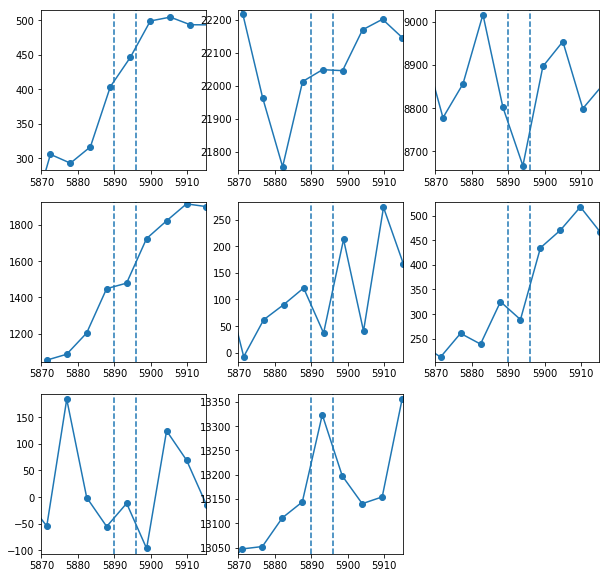

In [3]:
flist = glob.glob(os.path.join(EFOSC_DIR, '*ex.fits'))
fig = plt.figure(figsize=[10,10])
n_ax = len(flist)
n_side = math.ceil(math.sqrt(n_ax))
n_size = n_side

for i, ifile in enumerate(flist):
    ofile = fits.open(ifile)
    optimal_extra = ofile[0].data[0,0,:]
    wl = spec.calc_wavelength(ofile[0].header, np.arange(len(optimal_extra)))
    deredshift_wl = spec.apply_redshift(wl, redshift_15oz)
    ax = fig.add_subplot(n_side, n_size, i+1)
    plt.plot(deredshift_wl, optimal_extra, 'o-')
    plt.axvline(NaD2, linestyle='--')
    plt.axvline(NaD1, linestyle='--')
    plt.xlim(5870, 5915)
    
    lims = optimal_extra[(deredshift_wl > 5870)&(deredshift_wl<5915)]
    plt.ylim(np.min(lims)-10, np.max(lims)+10)
    

It doesnt

# Look at XSHOOTER Data

In [3]:
tbdata = ascii.read(os.path.join(XSHOOTER_DIR, 'ASASSN15oz_VLT_20150921.txt'), 
                    names=['wavelength', 'flux', 'flux_err'])

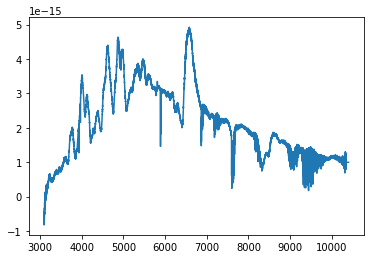

In [5]:
plt.plot(tbdata['wavelength'], tbdata['flux'])
#plt.xlim(5885, 5900)
#plt.ylim(1E-15, 3.5E-15)

In [6]:
gauss = models.GaussianAbsorption1D?

Object `models.GaussianAbsorption1D` not found.


In [ ]:
gauss = models.GaussianAbsorption1D

In [7]:
gauss = models.GaussianAbsorption1D

AttributeError: module 'astropy.modeling.models' has no attribute 'GaussianAbsorption1D'

In [ ]:
gauss_absorb_1d = models.Const1D(1)-models.Gaussian1D()

na_model = gauss_absorb_1d(mean1=5890) + gauss_absorb_1d(mean1=5896) + models.Const1D()

#na_model = models.GaussianAbsorption1D(mean=5890)+ \
#           models.GaussianAbsorption1D(mean=5896)+ \
#           models.Const1D()
#na_model = models.Lorentz1D(x_0=5890)+ \
#           models.Lorentz1D(x_0=5896)+ \
#           models.Const1D()
#na_model = models.Moffat1D(x_0=5890)+ \
#           models.Moffat1D(x_0=5896)+ \
#           models.Const1D()        
        
fitter = fitting.LevMarLSQFitter()

indx = (tbdata['wavelength']<=5900) & (tbdata['wavelength']>= 5887)

na_fit = fitter(na_model, tbdata['wavelength'][indx], tbdata['flux'][indx]/3E-15)


In [ ]:
plt.plot(tbdata['wavelength'], tbdata['flux'])
plt.xlim(5885, 5925)
#plt.ylim(1E-15, 3.5E-15)
x = np.arange(5885, 5905, 0.1)
plt.plot(x, na_fit(x)*3E-15)

na_fit

In [13]:

na_d2 = (models.Const1D()-models.Gaussian1D(mean=5890, bounds={'mean':[5889, 5891]}))

na_d1 = (models.Const1D()-models.Gaussian1D(mean=5896, bounds={'mean':[5895, 5897]}))

        
fitter = fitting.LevMarLSQFitter()

indx_d1 = (tbdata['wavelength']<=5900) & (tbdata['wavelength']>= 5893)
indx_d2 = (tbdata['wavelength']<=5893) & (tbdata['wavelength']>= 5887)
na_fit_d1 = fitter(na_d1, tbdata['wavelength'][indx_d1], tbdata['flux'][indx_d1]/3E-15)
na_fit_d2 = fitter(na_d2, tbdata['wavelength'][indx_d2], tbdata['flux'][indx_d2]/3E-15)

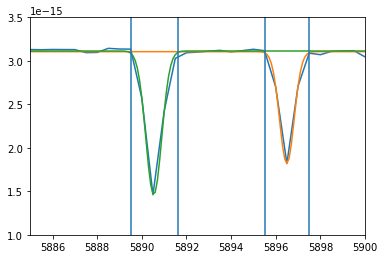

In [47]:
plt.plot(tbdata['wavelength'], tbdata['flux'])
plt.xlim(5885, 5900)
plt.ylim(1E-15, 3.5E-15)
x = np.arange(5885, 5905, 0.1)
plt.plot(x, na_fit_d1(x)*3E-15)
plt.plot(x, na_fit_d2(x)*3E-15)
plt.axvline(5889.5)
plt.axvline(5891.6)
plt.axvline(5895.5)
plt.axvline(5897.5)

In [19]:
d_lambda = 0.01
x_d2 = np.arange(5889.5, 5891.6, d_lambda)
model_flux_d2 = na_fit_d2(x_d2)
ew_d2 = np.sum((1-(model_flux_d2/na_fit_d2.amplitude_0))*d_lambda)
print('equivalent width for d2= {}'.format(ew_d2))
e_b_v_d2 = 10**(2.16*ew_d2-1.91)
print('E(B-V) for d1 using Poznanski 2012 = {}'.format(e_b_v_d2))

equivalent width for d2= 0.4727987799053884
E(B-V) for d1 using Poznanski 2012 = 0.12919489835735312


In [20]:
d_lambda = 0.01
x_d1 = np.arange(5895.5, 5897.5, d_lambda)
model_flux_d1 = na_fit_d1(x_d1)
ew_d1 = np.sum((1-(model_flux_d1/na_fit_d1.amplitude_0))*d_lambda)
print('equivalent width for d1= {}'.format(ew_d1))
e_b_v_d1 = 10**(2.47*ew_d1-1.76)
print('E(B-V) for d1 using Poznanski 2012 = {}'.format(e_b_v_d1))

equivalent width for d1= 0.3390142726834814
E(B-V) for d1 using Poznanski 2012 = 0.11949927034792594


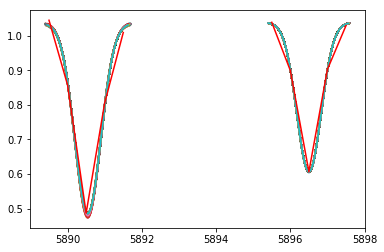

In [7]:
def calc_ew_err(wl, flux, wl_min, wl_max, wl_range, mean, mean_range, std=1.0, std_range=None, niter=100, dlambda=0.01):
    ew_arr = []
    wl_min = np.random.uniform(wl_min-wl_range, wl_min, size=niter)
    wl_max = np.random.uniform(wl_max, wl_max+wl_range, size=niter)
    mean = np.random.uniform(mean-mean_range/2, mean+mean_range/2, size=niter)
    if std_range:
        std = np.random.uniform(std-std_range/2, std+std_range/2, size=niter)
    else:
        std = np.ones(niter)*std
    for iwl_min, iwl_max, imean, istd in zip(wl_min, wl_max, mean, std):
        iwl = wl[(wl<=iwl_max)&(wl>=iwl_min)]
        iflux = flux[(wl<=iwl_max)&(wl>=iwl_min)]
        iew = calc_ew(iwl, iflux, iwl_min, iwl_max, imean, istd,dlambda=dlambda)
        ew_arr.append(iew)
    plt.plot(iwl, iflux, 'r')
    return ew_arr

def calc_ew(wl, flux, wl_min, wl_max, mean, std, dlambda=0.01):
    model = (models.Const1D()-models.Gaussian1D(mean=mean, stddev=std, bounds={'mean':[wl_min, wl_max]}))
    fitter = fitting.LevMarLSQFitter()
    fit_model = fitter(model, wl, flux)
    wl_mod = np.arange(wl_min, wl_max, dlambda)
    model_flux = fit_model(wl_mod)
    ew = np.sum((1-(model_flux/fit_model.amplitude_0))*dlambda)
    plt.plot(wl_mod, model_flux)
    return ew

scale=3E-15
ew_arr_d1 = calc_ew_err(tbdata['wavelength'], tbdata['flux']/scale, 5895.5, 5897.5, 0.1, 5896, 0.25, niter=700)
ew_arr_d2 = calc_ew_err(tbdata['wavelength'], tbdata['flux']/scale, 5889.5, 5891.6, 0.1, 5890.5, 0.25, niter=700)
ew_err_d1 = np.std(ew_arr_d1)
ew_err_d2 = np.std(ew_arr_d2)


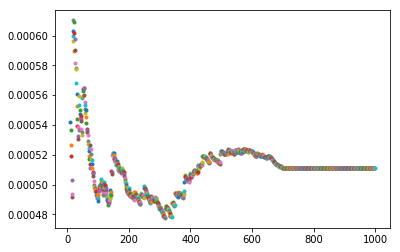

In [8]:
for n in range(10, 1000):
    plt.plot(n, np.std(ew_arr_d1[:n]), '.')

### This value is much much smaller (2 orders of magnitude) than the error on the zeropoint of the E(B-V) calculation

from Poznanski 2012:  
$log_{10}(E(B-V)) = 2.16*EW(D_2) - 1.91\pm 0.15$  --> $E(B-V) = 10^{2.16*EW(D_2) - 1.91\pm 0.15}$  
$log_{10}(E(B-V)) = 2.47*EW(D_1) - 1.76 \pm 0.17$  --> $E(B-V) = 10^{2.47*EW(D_1) - 1.76 \pm 0.17}$  

if unresolved:  
$log_{10}(E(B-V)) = 1.17*(EW(D_1+D_2)) - 1.85 \pm 0.08$ --> $E(B-V) = 10^{1.17*(EW(D_1+D_2)) - 1.85 \pm 0.08}$  
    

$E(B-V) = 10^{A*EW + zpt} = 10^x$

From Wolfram
$\frac{d(10^x)}{dx} = 10^x ln(10)$



$\frac{d(E(B-v))}{d(zpt)} = 10^x*ln(10)\frac{dx}{dzpt} = 10^x*ln(10)$   
$\frac{d(E(B-v))}{d(EW)} = 10^x*ln(10)\frac{dx}{dEW} = 10^x*ln(10)*A$



In [15]:
zpt_d1 = -1.76
zpt_d2 = -1.91
A_d1 = 2.47
A_d2 = 2.16
sig_zpt_d1 = 0.17
sig_zpt_d2 = 0.15
ew_d1 = np.mean(ew_arr_d1)
ew_d2 = np.mean(ew_arr_d2)
sig_ew_d1 = np.std(ew_arr_d1)
sig_ew_d2 = np.std(ew_arr_d2)

x_d1 = A_d1*ew_d1 + zpt_d1
x_d2 = A_d2*ew_d2 + zpt_d2

partial_zpt_d1 = 10**x_d1 * np.log(10)
partial_zpt_d2 = 10**x_d2 * np.log(10)
partial_ew_d1 = 10**x_d1 * np.log(10) * A_d1
partial_ew_d2 = 10**x_d2 * np.log(10) * A_d2

ebv_d1 = 10**x_d1
ebv_d2 = 10**x_d2

sig_ebv_d1 = np.sqrt(partial_zpt_d1**2 * sig_zpt_d1**2 + partial_ew_d1**2 * sig_ew_d1**2)
sig_ebv_d2 = np.sqrt(partial_zpt_d2**2 * sig_zpt_d2**2 + partial_ew_d2**2 * sig_ew_d2**2)

print('E(B-V) from D1 line: {:2.4f}+/-{:2.2f}'.format(ebv_d1, sig_ebv_d1))
print('E(B-V) from D2 line: {:2.4f}+/-{:2.2f}'.format(ebv_d2, sig_ebv_d2))
ebv = (ebv_d1+ebv_d2)/2
sig_ebv = np.sqrt(sig_ebv_d1**2+sig_ebv_d2**2)
print('E(B-V) avg: {:2.4f} +/- {:2.2f}'.format(ebv, sig_ebv))

E(B-V) from D1 line: 0.1222+/-0.05
E(B-V) from D2 line: 0.1284+/-0.04
E(B-V) avg: 0.1253 +/- 0.07


# Check equivalent width calculation

In [97]:
norm_flux = tbdata['flux'][indx_d1]/np.median(tbdata['flux'][indx_d1])

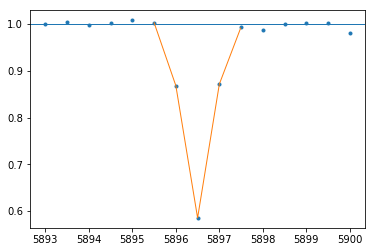

In [103]:
plt.plot(tbdata['wavelength'][indx_d1], norm_flux, 'o')
plt.axhline(1)
high_sample = np.interp(x_d1, tbdata['wavelength'][indx_d1], norm_flux)
plt.plot(x_d1,high_sample)

In [108]:
np.sum(d_lambda*(1-high_sample))

0.33857150989475993

## Values are correct. Close to Schlafly & Finkbierner 2011 - adopting that value

In [19]:
a = gauss_absorb_1d(mean_1=1)
b = gauss_absorb_1d(mean_1)

<CompoundModel9(amplitude_0=1., amplitude_1=1., mean_1=0., stddev_1=1.)>